# Least-Squares Background Fitting
We attempt to fit a range of polynomial functions to the background using a linear least-squares fitting routine as implemented by SciPy. This is a binned fitting routine. Optimised parameters are retained in this notebook and in the more general data directory.

In [65]:
import numpy as np
from scipy.optimize import curve_fit
import pandas
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import sys
sys.path.append('../')
from dataflow import Flow

In [66]:
NBINS = 100

## Fetch Mass Distribution
We need to construct an actual background mass distribution to fit from. We will use the background data as given in the real tuple and restrict the sidebands to the values the neural network is currently using. We will also want to try the optimisation using a variety of bin widths.

In [67]:
sname = "/disk/moose/lhcb/djdt/Lb2L1520mueTuples/MC/2016MD/fullSampleOct2021/job207-CombDVntuple-15314000-MC2016MD_Full-pKmue-MC.root"
fname = "/disk/moose/lhcb/djdt/Lb2L1520mueTuples/realData/2016MD/halfSampleOct2021/blindedTriggeredL1520Selec-collision-firstHalf2016MD-pKmue_Fullv9.root"

my_flow = Flow(['Lb_M'], sname, fname, common_features_fname='../code/common_features')
df = my_flow.get_combined_data()

WARN: The dataframes are empty or pre-selection has not been applied
WARN: Attempting empty preselection and recombination
INFO: Removing events with missing values...
INFO: 0 background and 0 signal events were removed


In [68]:
background_data = df[df['category'] == 0].copy()
# Select all the background events, this includes some simulated Monte-Carlo data

background_data.drop(['category'], axis=1, inplace=True)
# Remove the now defunct column of category

background_data = background_data[background_data['Lb_M'].between(4500, 5200) | background_data['Lb_M'].between(5800, 6500)]
# Restrict the mass sidebands to that used by the neural network and quoted by Dan

## Bin the Distribution
Now that we have a dataframe with all the background events we care about it is now prudent to fit our background functions to this. Before doing this these data should be put into bins. The value of bins is variable and will affect the final fit. For this reason we choose the finest bin structure possible.

In [69]:
background_data = background_data.to_numpy().flatten()
# Take the dataframe and make into a flat 1D array

In [88]:

bins = np.linspace(np.min(background_data), np.max(background_data), NBINS+1)
bin_width = bins[1] - bins[0]
bin_centres = np.array([np.mean(bins[i:i+2]) for i in range(len(bins)-1)])

freqs, _ = np.histogram(background_data, bins)
# Use a normalised histogram to avoid enormous values as polynomial coefficients

data = np.array([bin_centres, freqs, np.sqrt(freqs)]).T
# Combine the bin centres, frequencies and error on these frequencies into a larger array

data = data[np.where(data[:,1] != 0), :].squeeze()
data = np.delete(data, [34, 35], axis=0)
# Remove all the empty bins and the 'edge' bins

## Visual Analysis
The best way to get a feel for these data is to do an initial visual analysis. We can do this by plotting the mass distribution and seeing what sort of shape it seems to take. We might normally expect a combinatorial background to be exponentially decaying excluding any resonances.

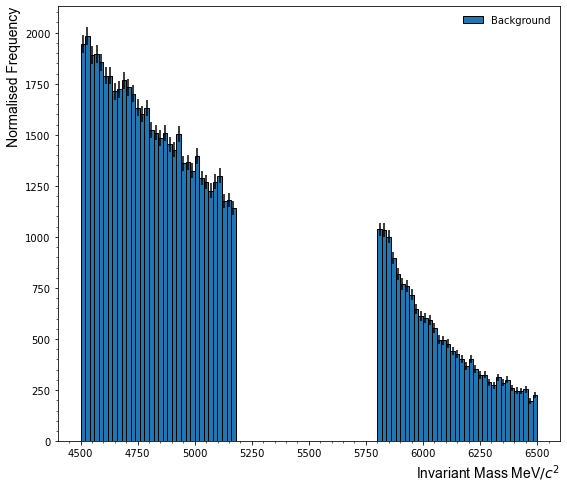

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(9, 8))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
fonts = {'fontname':'Arial'}

ax.bar(data[:,0], data[:,1], width=bin_width, yerr=data[:,2], label='Background', edgecolor='k')

plt.ylabel('Normalised Frequency', horizontalalignment='right', y=1.0, fontsize=14, **fonts)
plt.xlabel(r'Invariant Mass MeV$/c^2$', horizontalalignment='right', x=1.0, fontsize=14, **fonts)
plt.legend(loc='upper right', ncol=1, fancybox=False, shadow=True, frameon=False)
plt.show()

## Fitting Polynomials